<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Альтернативное-решиение-с-использованием-Bert" data-toc-modified-id="Альтернативное-решиение-с-использованием-Bert-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Альтернативное решиение с использованием Bert</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» - 

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tqdm
import warnings
import re
import nltk
import torch
import sys
import spacy

from sklearn.utils import resample, shuffle
from sklearn.metrics import f1_score

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from nltk.corpus import stopwords as nltk_stopwords

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import transformers as ppb

from sklearn.pipeline import Pipeline

from tqdm.notebook import tqdm
from wordcloud import WordCloud


warnings.filterwarnings("ignore")

In [2]:
tqdm.pandas()

In [3]:
try:
    df= pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
except:
    df=pd.read_csv('/Users/aleksandrivanov/Downloads/toxic_comments.csv', index_col=0)
pd.set_option('display.max_columns', None)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [7]:
df.describe()

,toxic
count,159292.000000
mean,0.101612
std,0.302139
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [8]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


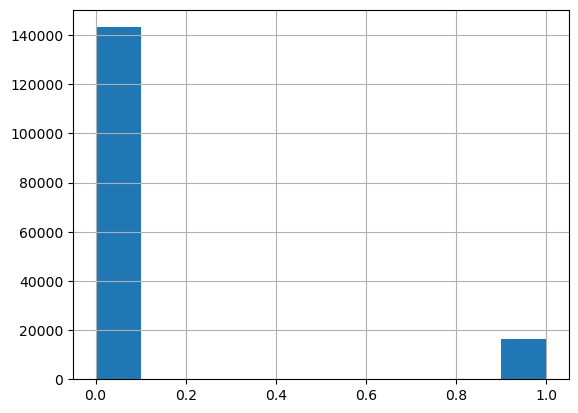

In [9]:
df['toxic'].hist()
plt.show()

In [10]:
df.sample(10)

,text,toxic
31069,Death year a friend has a letter from W.D.M. ...,0
155102,You missed one. We can play this game all night,0
63484,">>>Nijdam, let me try to turn this problem rou...",0
8382,Save your sarcastic little remarks DICK. Ok D...,1
34775,"""On Tom Waits' """"Orphans"""" album, he includes ...",0
29257,"""\n\nWhat a waffle. Yep. Its """"neither begets ...",0
30317,That's not fair. A majority of the world haven...,0
131392,It might do me well to think about Czech gramm...,0
133470,"""\n\nCan you upload this picture (note the Agg...",0
20249,yeah \n\nbut scientology is still a fucking jo...,1


сильный дисбаланс, 140 тысяч против 20, надо бы исправить позже

In [11]:
corpus = list(df['text'])

In [12]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [13]:
def lemmatize(text): # токенизация и лемматизация
    wnl = WordNetLemmatizer()
    lemm_list =[wnl.lemmatize(x,get_wordnet_pos(x)) for x in text.split()]
    lemm_text = " ".join(lemm_list)
    return lemm_text

In [14]:
nlp = spacy.load("en_core_web_sm")

In [15]:
def lemmatizee(text):
    doc = nlp(text)
    lemm_list = [token.lemma_ for token in doc]
    lemm_text = " ".join(lemm_list)
    return lemm_text

In [16]:
def clear_text(text): #очищение текста
    clear_text = re.sub(r"[^a-zA-Z']", ' ', text)
    clear_text = " ".join(clear_text.split())
    return clear_text.lower()

In [17]:
print("Очищенный и лемматизированный текст:", lemmatizee(clear_text(corpus[0])))

Очищенный и лемматизированный текст: explanation why the edit make under my username hardcore metallica fan be revert they be not vandalism just closure on some gas after I vote at new york doll fac and please do not remove the template from the talk page since I be retire now


In [18]:
df['lemma_text']=df['text'].progress_apply( lambda x: lemmatizee(clear_text(x)))

  0%|          | 0/159292 [00:00<?, ?it/s]

In [19]:
df

,text,toxic,lemma_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,d'aww he match this background colour I be see...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man I be really not try to edit war it be ...
3,"""\nMore\nI can't make any real suggestions on ...",0,more I can not make any real suggestion on imp...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...
...,...,...,...
159446,""":::::And for the second time of asking, when ...",0,and for the second time of ask when your view ...
159447,You should be ashamed of yourself \n\nThat is ...,0,you should be ashamed of yourself that be a ho...
159448,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm there s no actual article for pros...
159449,And it looks like it was actually you who put ...,0,and it look like it be actually you who put on...


In [20]:
%matplotlib inline
text_help = " ".join(df['lemma_text'])
wordcloud = WordCloud().generate(text_help )

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюераV2</b></font>

Совет 🤔:



Так ты его не вывел.  И информативнее строить отдельно для токсичных и нетоксичных
    
    
    
    !/opt/conda/bin/python -m pip install wordcloud
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt


    df_negative = df[df['toxic'] == 1]
    text_cloud = ' '.join(df_negative['text'])
    cloud = WordCloud(stopwords=stopwords, max_words=80, collocations=False).generate(text_cloud)
    plt.figure(figsize=(12,8))
    plt.imshow(cloud)
    plt.axis('off')
    plt.show()   





In [1]:
df_negative = df[df['toxic'] == 1]
text_cloud = ' '.join(df_negative['text'])
cloud = WordCloud(stopwords=stopwords, max_words=80, collocations=False).generate(text_cloud)
plt.figure(figsize=(12,8))
plt.imshow(cloud)
plt.axis('off')
plt.show() 

NameError: name 'df' is not defined

In [ ]:
lemma_text

In [21]:
features = df.drop(['toxic'], axis=1)
target = df['toxic']

In [22]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345, stratify = target)

In [23]:
corpus = features_train['lemma_text'].values

nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=list(stopwords)) 
tf_idf = count_tf_idf.fit_transform(corpus)

print("Размер матрицы:", tf_idf.shape)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aleksandrivanov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Размер матрицы: (127433, 133217)


## Обучение

 попробуем нашу модель на логистической регрессии

In [25]:
%%time
params={'model__C':[.01,.05,.1,.5,1,5,10],
           'model__penalty':['l1','l2']}
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=list(stopwords))),
    ('model',LogisticRegression(max_iter = 1000, random_state = 12345))])
grid_log = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=params ,scoring='f1')
grid_log.fit(features_train['lemma_text'], target_train)

CPU times: user 10.6 s, sys: 2.69 s, total: 13.3 s
Wall time: 48.1 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words=['you',
                                                                    'isn', 'if',
                                                                    'itself',
                                                                    'his',
                                                                    "couldn't",
                                                                    'hers',
                                                                    'into',
                                                                    've',
                                                                    "you'd",
                                                                    'shouldn',
                                                                    "she's",
                                                                    'myself',
                                                                    'couldn',
                                                                    'these',
                                                                    'in',
                                                                    'than',
                                                                    'too',
                                                                    'what',
                                                                    'ourselves',
                                                                    'having',
                                                                    'mustn',
                                                                    "needn't",
                                                                    'to', 'any',
                                                                    'off', 'no',
                                                                    'all',
                                                                    'very',
                                                                    'own', ...])),
                                       ('model',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=12345))]),
             n_jobs=-1,
             param_grid={'model__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10],
                         'model__penalty': ['l1', 'l2']},
             scoring='f1')

In [26]:
print(grid_log.best_score_)

0.7768952556586477


попробуем деревянную модель 

In [28]:
parameters_fr = {'max_depth' : range(1,9),
                'n_estimators': range(1, 40)} #я понимаю, что это не лес, а опушка какая-то, но очень долго считает

In [30]:
%%time
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=list(stopwords))),
    ('rt',RandomForestClassifier(random_state=12345, class_weight = 'balanced'))])
parameters_fr = {'rt__max_depth' : range(7,12),
                'rt__n_estimators': range(35, 50)} #я понимаю, что это не лес, а опушка какая-то, но очень долго считает
fr_grid_model = GridSearchCV(pipeline, cv=3, n_jobs=-1, param_grid=parameters_fr, scoring='f1')
fr_grid_model.fit(features_train['lemma_text'], target_train)

CPU times: user 10.2 s, sys: 4.01 s, total: 14.2 s
Wall time: 2min 8s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words=['you',
                                                                    'isn', 'if',
                                                                    'itself',
                                                                    'his',
                                                                    "couldn't",
                                                                    'hers',
                                                                    'into',
                                                                    've',
                                                                    "you'd",
                                                                    'shouldn',
                                                                    "she's",
                                                                    'myself',
                                                                    'couldn',
                                                                    'these',
                                                                    'in',
                                                                    'than',
                                                                    'too',
                                                                    'what',
                                                                    'ourselves',
                                                                    'having',
                                                                    'mustn',
                                                                    "needn't",
                                                                    'to', 'any',
                                                                    'off', 'no',
                                                                    'all',
                                                                    'very',
                                                                    'own', ...])),
                                       ('rt',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=12345))]),
             n_jobs=-1,
             param_grid={'rt__max_depth': range(7, 12),
                         'rt__n_estimators': range(35, 50)},
             scoring='f1')

In [31]:
print(fr_grid_model.best_params_)
print(fr_grid_model.best_score_)

{'rt__max_depth': 11, 'rt__n_estimators': 49}
0.3712507980966661


In [34]:
%%time
catboost = CatBoostClassifier(eval_metric = 'F1', verbose = False)
cat_m = catboost.fit(tf_idf, target_train, verbose = False)

CPU times: user 25min 52s, sys: 9.57 s, total: 26min 1s
Wall time: 4min 37s


In [35]:
print(cat_m.best_score_)

{'learn': {'Logloss': 0.10282271617263541, 'F1': 0.8008544346046016}}


lightGBM

In [37]:
# %%time
param_grid = {
    'num_leaves': [10, 20, 31, 40, 50],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [10, 20]
  }
# grid_lgb = GridSearchCV(estimator=LGBMClassifier(), param_grid=param_grid, cv=3, scoring = 'f1')
# grid_lgb.fit(tf_idf, target_train)

In [38]:
%%time
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=list(stopwords))),
    ('lgb',LGBMClassifier(random_state=12345, class_weight = 'balanced'))])
param_grid = {
    'lgb__num_leaves': [10, 20, 31, 40, 50],
    'lgb__learning_rate': [0.05, 0.1],
    'lgb__n_estimators': [10, 20]}
grid_lgb = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=param_grid, scoring='f1')
grid_lgb.fit(features_train['lemma_text'], target_train)

CPU times: user 33.4 s, sys: 8.6 s, total: 42 s
Wall time: 3min 5s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words=['you',
                                                                    'isn', 'if',
                                                                    'itself',
                                                                    'his',
                                                                    "couldn't",
                                                                    'hers',
                                                                    'into',
                                                                    've',
                                                                    "you'd",
                                                                    'shouldn',
                                                                    "she's",
                                                                    'myself',
                                                                    'couldn',
                                                                    'these',
                                                                    'in',
                                                                    'than',
                                                                    'too',
                                                                    'what',
                                                                    'ourselves',
                                                                    'having',
                                                                    'mustn',
                                                                    "needn't",
                                                                    'to', 'any',
                                                                    'off', 'no',
                                                                    'all',
                                                                    'very',
                                                                    'own', ...])),
                                       ('lgb',
                                        LGBMClassifier(class_weight='balanced',
                                                       random_state=12345))]),
             n_jobs=-1,
             param_grid={'lgb__learning_rate': [0.05, 0.1],
                         'lgb__n_estimators': [10, 20],
                         'lgb__num_leaves': [10, 20, 31, 40, 50]},
             scoring='f1')

In [39]:
print(grid_lgb.best_params_)
print(grid_lgb.best_score_)

{'lgb__learning_rate': 0.1, 'lgb__n_estimators': 20, 'lgb__num_leaves': 50}
0.7037335709405599


XGB

In [40]:
# %%time
params_xgb = {
        'n_estimators': [10,50],
        'max_depth': [3, 8],
        'eta': [0.5, 1]
        }
# grid_xgb = GridSearchCV(XGBClassifier(), params_xgb, n_jobs=-1, scoring = 'f1', cv = 3)

# grid_xgb.fit(tf_idf, target_train)


In [41]:
%%time
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=list(stopwords))),
    ('xgb',XGBClassifier(random_state=12345))])
params_xgb = {
        'xgb__n_estimators': [10,50, 100],
        'xgb__max_depth': [3, 8],
        'xgb__eta': [0.5, 1]
        }
grid_xgb = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=params_xgb, scoring='f1')
grid_xgb.fit(features_train['lemma_text'], target_train)

[23:01:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

CPU times: user 1min 37s, sys: 7.17 s, total: 1min 44s
Wall time: 4min 18s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words=['you',
                                                                    'isn', 'if',
                                                                    'itself',
                                                                    'his',
                                                                    "couldn't",
                                                                    'hers',
                                                                    'into',
                                                                    've',
                                                                    "you'd",
                                                                    'shouldn',
                                                                    "she's",
                                                                    'myself',
                                                                    'couldn',
                                                                    'these',
                                                                    'in',
                                                                    'than',
                                                                    'too',
                                                                    'what',
                                                                    'ourselves',
                                                                    'having',
                                                                    'mustn',
                                                                    "needn't",
                                                                    'to', 'any',
                                                                    'off', 'no',
                                                                    'all',
                                                                    'very',
                                                                    'own', ...])),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booste...
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None, ...))]),
             n_jobs=-1,
             param_grid={'xgb__eta': [0.5, 1], 'xgb__max_depth': [3, 8],
                         'xgb__n_estimators': [10, 50, 100]},
             scoring='f1')

In [42]:
print(grid_xgb.best_params_)
print(grid_xgb.best_score_)

{'xgb__eta': 0.5, 'xgb__max_depth': 8, 'xgb__n_estimators': 100}
0.7599711744417805


лучший показатель получился на обычном catboost, единственное, я не совсем с ним понял, есть ли там встроенная кросс валидация? проверим нашу наилучшую модель на тестовой выборке

In [43]:
corpus_test = features_test['lemma_text'].values

nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
#count_tf_idf_test = TfidfVectorizer(stop_words=list(stopwords)) 
tf_idf_test = count_tf_idf.transform(corpus_test)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aleksandrivanov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [44]:
cat_predict = cat_m.predict (tf_idf_test)

In [45]:
print (f1_score(target_test, cat_predict))

0.7565248480514836


## Выводы

Общие выводы:
Были проведены следующие этапы обработки/подготовки данных:
1. Осмотр датасета
2. Проверка на пропуски, аномалии, отклонения, данные подготовлены
3. Созданы функции для очистки данных и лемматизации данных
4. Далее данные разбиты на тест и трейн
5. Далее выполнена веторизация данных
6. Проведено обучение на нескольких вариантах моделей, лучшшее значение получилось на моделе Catboost, проверили её на тестовой выбокре и получили значение f1 0.75, что соответствует требованиям заказчика